<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**
* Watch tutorial

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
from torch.nn.parameter import Parameter
import pdb

In [ ]:
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
  def __getitem__(self, i):
    x,y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)


___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**


**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform


In [ ]:
class CrossEntropyLoss(nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()

  def forward(self, input, target):
    rows = input.size(0)
    # exp = torch.exp(input)
    # log_exp = torch.log(torch.sum(exp, dim=1, keepdim=True))
    log_exp = torch.logsumexp(input, dim=1, keepdim=True)
    loss = -input[range(rows), target] + log_exp

    # exp = torch.exp(input)
    # sum_row = torch.sum(exp,1, keepdim=True)

    # r = torch.arange(exp.size(0))
    # c = target
    # s = torch.transpose(sum_row[r], 0, 1)

    # softmax = torch.divide(exp[r,c], s)

    # loss = -torch.log(softmax).mean()

    return loss.mean()

class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, init_method, stride=1, padding=0, dilation=1, groups=1, bias=True):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    self.weight = Parameter(torch.Tensor(out_channels,in_channels,*kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))

    if init_method == "xe":
        fan_in = in_channels * kernel_size[0] * kernel_size[1]
        fan_out = out_channels *  kernel_size[0] * kernel_size[1]
        variance = 2 / (fan_in + fan_out)
        self.weight.data = torch.from_numpy(np.random.normal(scale=variance ** .5, size=self.weight.data.shape)).float()
    elif init_method == "orthogonal":
        X = np.random.random((out_channels, in_channels, kernel_size[0], kernel_size[1]))
        _, _, Vt = np.linalg.svd(X, full_matrices=False)
        self.weight.data = torch.from_numpy(Vt.reshape(out_channels, in_channels, *kernel_size)).float()
    elif init_method == "uniform":
      self.weight.data.uniform_(-1,1)
    else:
      raise Exception(f"ERROR: unrecognized initialization: {init_method}")

    self.bias.data.uniform_(0,0)


  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)

In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset, init_method='uniform'):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10 

    self.net = nn.Sequential(
      Conv2d(c, 500, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(500, 122, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(122, 115, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(115, 112, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(112, 96, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(96, 80, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(80, 64, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(64, 48, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(48, 32, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(32, 16, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(16, 10, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(10, 10, (3,3), padding=(1,1), init_method=init_method),
      nn.ReLU(),
      Conv2d(10, output, (28,28), padding=(0,0), init_method=init_method),
    )

  def forward(self,x):
    return self.net(x).squeeze(2).squeeze(2)


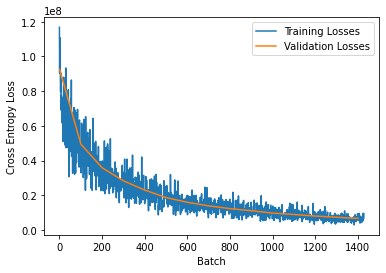

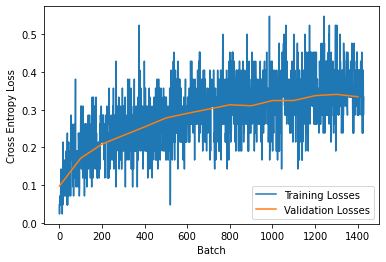

Max Validation Accuracy:  0.3405558963201036


In [ ]:
# Initialize Datasets


train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=42,
                          shuffle=True,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=42,
                        pin_memory=True)

# Initialize Model

init_method = 'orthogonal'
model = ConvNetwork(train_dataset, init_method=init_method)
model = model.cuda()

# Initialize Objective and Optimizer and other parameters

objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs= 7
val_frequency = 100

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  loop = tqdm(total=len(train_loader), position=0, leave=False)

  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)

    loss = objective(y_hat, y_truth)
    loss.backward()
    train_losses.append(loss.item())

    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    train_accuracy.append(accuracy.item())

    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), accuracy.item()))
    loop.update(True)

    optimizer.step()

    if batch % val_frequency == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                    for x, y in val_loader])

      accuracy = np.mean([(model(x.cuda()).argmax(1) == y.cuda()).float().mean().item()
                              for x, y in val_loader])
      val_losses.append((len(train_losses), val))
      val_accuracy.append((len(train_accuracy), accuracy))

  loop.close()

a,b = zip(*val_losses)
plt.plot(train_losses, label='Training Losses')
plt.plot(a, b, label='Validation Losses')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

c,d = zip(*val_accuracy)
plt.plot(train_accuracy, label='Training Losses')
plt.plot(c,d, label='Validation Losses')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

print('Max Validation Accuracy: ', np.max(np.array(d)))



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model 

**DONE:**


Uniform Initialization


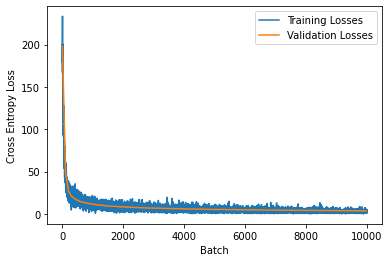

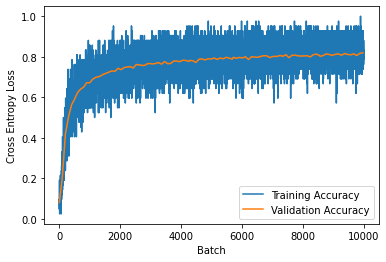

Max Validation Accuracy:  0.819585593923864


In [ ]:
# Go back up and try a few different networks and initialization strategies
# Plot training and validation loss for uniform initialization
# Plot training and validation accuracy for uniform initialization

print("Uniform Initialization")

a,b = zip(*val_losses)
plt.plot(train_losses, label='Training Losses')
plt.plot(a, b, label='Validation Losses')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

c,d = zip(*val_accuracy)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(c,d, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

print('Max Validation Accuracy: ', np.max(np.array(d)))


Xe Initialization


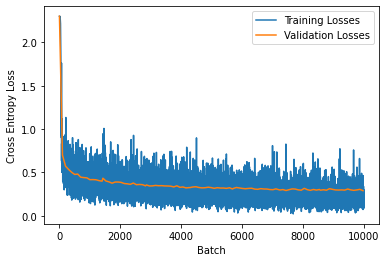

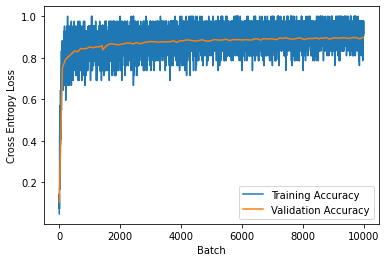

Max Validation Accuracy:  0.8979876669879737


In [ ]:
# Plot training and validation loss for Xe initialization
# Plot training and validation accuracy for Xe initialization
print("Xe Initialization")

a,b = zip(*val_losses)
plt.plot(train_losses, label='Training Losses')
plt.plot(a, b, label='Validation Losses')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

c,d = zip(*val_accuracy)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(c,d, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

print('Max Validation Accuracy: ', np.max(np.array(d)))


Orthogonal Initialization


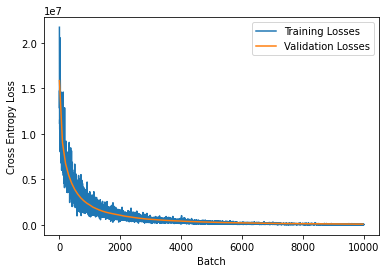

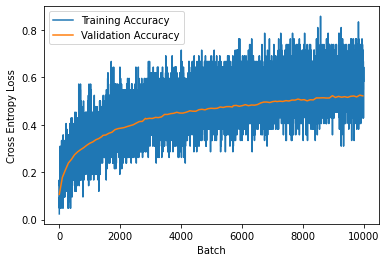

Max Validation Accuracy:  0.5246563141066659


In [ ]:
# Plot training and validation loss for orthogonal initialization
# Plot training and validation accuracy for orthogonal initialization
print("Orthogonal Initialization")

a,b = zip(*val_losses)
plt.plot(train_losses, label='Training Losses')
plt.plot(a, b, label='Validation Losses')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

c,d = zip(*val_accuracy)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(c,d, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

print('Max Validation Accuracy: ', np.max(np.array(d)))


In [ ]:
num_params= sum([torch.numel(layer) for layer in model.parameters()])
print(num_params)

1135693


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : out_channels=22, kernel_size=(3, 3), padding=(1, 1)
*(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) :(out_channels=65, kernel_size=(3, 3), padding=(2, 2)
*(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : out_channels=7, kernel_size=(3, 3), padding=(6, 6)

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **out_channels=100, kernel_size=(5, 5), padding=(2, 2)**
*(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) :**out_channels=23, kernel_size=(5, 5), padding=(3, 3)**
*(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **out_channels=5, kernel_size=(5, 5), padding=(9, 9)**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **out_channels=10, kernel_size=(5, 3), padding=(1, 0)**
*(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **out_channels=100, kernel_size=(5, 3), padding=(2, 1)**
*(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **out_channels=23, kernel_size=(5, 3), padding=(3, 2)**
*(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **out_channels=5, kernel_size=(5, 3), padding=(9, 8)**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : o**ut_channels=10, kernel_size=(2, 4), padding=(0, 0)**
*(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **out_channels=22, kernel_size=(1, 1), padding=(0, 0)**

**TODO:**

**DONE:**

* Answer all the questions above 


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
def testcode(input, output, out, kernel, padding):
  test_case = Conv2d(input[0], out, kernel_size=kernel, padding=padding)
  test_size = test_case(torch.zeros(1, *input)).size()
  correct_mapping = (test_size[1:])
  print(correct_mapping)
  print(output)

testcode((3,10,10), (22,10,10), out=22, kernel=(1,1), padding=(0,0))

torch.Size([22, 10, 10])
(22, 10, 10)
